In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

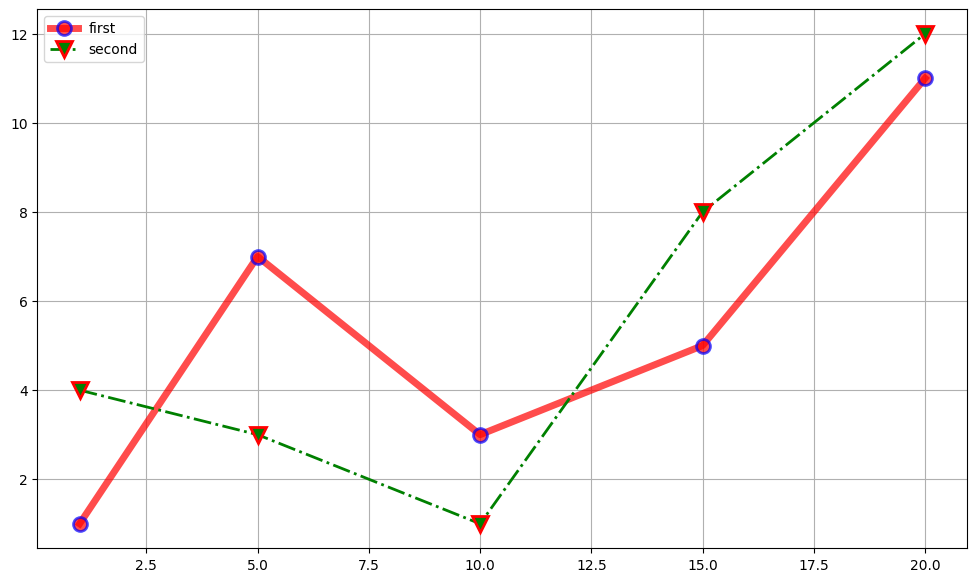

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torchmetrics.text import WordErrorRate
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m, EfficientNet_V2_S_Weights, efficientnet_v2_s
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import os
import json
import copy
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sacrebleu import corpus_bleu
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image
import re

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing

os.environ["TOKENIZERS_PARALLELISM"] = "true"

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = ["_".join(path.parts[-3:-2][0].split("_")[:level]) for path in img_paths]
    if level != 1:
        model_name = "_".join(target[0].split("_")[:level-1])
    else:
        model_name = "full_model"
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))

    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target


def get_traintestsplit(categories : list[str],
                       data_dir : Path,
                       SEED : int,
                       feedbacks : bool = False,
                       train_val : bool = False,
                       ):
    
    full_train_paths, full_test_paths, full_val_paths = [], [], []
    for cat in categories:
        img_paths, target_enc, _, _ = get_target(data_dir,
                                                 feedbacks=False,
                                                 level=2,
                                                 category1=cat)

        train_paths, test_paths, ytrain, _ = train_test_split(img_paths, target_enc,
                                                         test_size=0.2,
                                                         stratify=target_enc,
                                                         random_state=SEED)
        if train_val:
            train_paths, val_paths, _, _ = train_test_split(train_paths, ytrain,
                                                             test_size=0.15,
                                                             stratify=ytrain,
                                                             random_state=SEED)
            full_val_paths.extend(val_paths)
        
        full_train_paths.extend(train_paths)
        full_test_paths.extend(test_paths)
        
    return full_train_paths, full_test_paths, full_val_paths

In [6]:
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

In [7]:
def delete_none_items(paths: list[Path],
                      descriptions: pd.DataFrame,
                      embeddings: torch.Tensor):
    
    descriptions.reset_index(inplace=True)
    ind_isna = descriptions[descriptions["description"].isna()].index.tolist()
    ind_notna = descriptions[descriptions["description"].notna()].index.tolist()
    
    # удаление
    descriptions.drop(index=ind_isna, inplace=True)
    descriptions.reset_index(drop=True, inplace=True)
    paths = list(pd.DataFrame(paths, columns=["paths"]).drop(index=ind_isna)["paths"])
    embeddings = torch.index_select(embeddings, dim=0, index=torch.from_numpy(np.array(ind_notna)))
    
    return paths, descriptions, embeddings


def text_prepocessing(text: str) -> str:
    text = text.lower()
    #text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text


def get_descriptions_and_embeds(paths: list[Path]):
    descriptions = []
    embeddings_check = False
    
    for path in paths:
#         print(path)
        line = pd.read_csv(path.parents[1] / "descriptions.csv", index_col="item").loc[path.name]
        descriptions.append(line)
        
        embed = pd.read_csv(path.parents[1] / "embeddings.csv", index_col="item").loc[path.name]["embedding"].encode().decode('unicode-escape').encode('ISO-8859-1')[2:-1]
        embed = torch.from_numpy(np.copy(np.frombuffer(embed, dtype=np.float32))).view(1, -1)
        if embeddings_check:
            embeddings = torch.cat([embeddings, embed], dim=0)
        else:
            embeddings = torch.cat([embed], dim=0)
            embeddings_check = True
        
        
    df = pd.DataFrame(descriptions)
    paths, df, embeddings = delete_none_items(paths, df, embeddings)
    df['descriptions_preproc'] = df.description.apply(text_prepocessing)
    return df, embeddings, paths


def get_tokenizer(df_descriptions, saving : bool = False):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"])

    # обучение
    tokenizer.train_from_iterator(df_descriptions["descriptions_preproc"], trainer=trainer)
    
    # создаем шаблон, как надо выдавать предложения
    tokenizer.post_processor = TemplateProcessing(
        single="[BOS] $A [EOS]",
        special_tokens=[
            ("[BOS]", tokenizer.token_to_id("[BOS]")),
            ("[EOS]", tokenizer.token_to_id("[EOS]")),
        ],
    )
    
    if saving:
        # сохранили в файл
        tokenizer.save("tokenizer.json") 
    
    return tokenizer

In [8]:
#tokenizer.token_to_id("[PAD]")
#tokenizer.encode("маша мыла раму. петя пишет AAA там тут и сям. +").ids

In [9]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "data_embed_test"

TRAIN_VAL = True

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, target2idx, idx2target = get_target(data_dir,
                                                  feedbacks=False,
                                                  level=1,
                                                  category1="Обувь",
                                                  category2="Детская&электроника")
train_paths, test_paths, val_paths = get_traintestsplit(categories=sorted(target2idx.keys()),
                                                        data_dir=data_dir,
                                                        SEED=SEED,
                                                        train_val=TRAIN_VAL)
print(len(train_paths), len(test_paths), len(val_paths))

195 58 35


In [10]:
# удаление категорий, где в описании спарсился брак
defective_categories = ["Автотовары_Запчасти&на&легковые&автомобили_Система&выпуска",
                        "Аксессуары_Чемоданы&и&защита&багажа",
                        "Детям_Детская&электроника_Системы&безопасности",
                        "Дом_Досуг&и&творчество_Профессиональные&музыкальные&инструменты",
                        "Дом_Кухня_Кастрюли&и&сковороды",
                        "Дом_Кухня_Кухонный&декор",
                        "Дом_Предметы&интерьера_Бары,&фонтаны,&камины",
                        "Дом_Предметы&интерьера_Картины&и&постеры_Доски&для&записей",
                        "Дом_Предметы&интерьера_Картины&и&постеры_Модульные&картины",
                        "Дом_Предметы&интерьера_Термометры,&барометры",
                        "Дом_Спальня_Постельные&принадлежности_Держатели&для&простыни",
                        "Дом_Спальня_Постельные&принадлежности_Фиксаторы&для&одеяла",
                        "Красота_Парфюмерия_Детские&ароматы",
                        "Красота_Парфюмерия_Мужские&ароматы_Прочие",
                        "Мебель_Мебель&для&спальни_Кровати&для&спальни",
                        "Электроника_Автоэлектроника&и&навигация_Автокосметика&и&автохимия",
                        "Электроника_Смартфоны&и&телефоны_Стилусы",]

train_paths = [path for path in train_paths if path.parts[-3:-2][0] not in defective_categories]
test_paths = [path for path in test_paths if path.parts[-3:-2][0] not in defective_categories]
val_paths = [path for path in val_paths if path.parts[-3:-2][0] not in defective_categories]
print(len(train_paths), len(test_paths), len(val_paths))

195 58 35


In [11]:
descriptions_train, embeddings_train, train_paths = get_descriptions_and_embeds(train_paths)
descriptions_test, embeddings_test, test_paths = get_descriptions_and_embeds(test_paths)
if TRAIN_VAL:
    descriptions_val, embeddings_val, val_paths = get_descriptions_and_embeds(val_paths)

tokenizer = get_tokenizer(descriptions_train)
print(tokenizer.get_vocab_size())                       # посмотрим на размер словаря

print(len(train_paths), len(test_paths), len(val_paths))
descriptions_train

8922
192 58 35


,index,description,descriptions_preproc
0,11.png,Часы мужские наручные серебро 925 пробы коллек...,часы мужские наручные серебро 925 пробы коллек...
1,10.png,Кольцо из высокотехнологичной керамики со вста...,кольцо из высокотехнологичной керамики со вста...
2,5.png,Ювелирный пирсинг в пупок из серебра 925 пробы...,ювелирный пирсинг в пупок из серебра 925 пробы...
3,12.png,Брошь из серебра 925 пробы Павлин с фианитами ...,брошь из серебра 925 пробы павлин с фианитами ...
4,13.png,Женские серебряные браслеты от петербургского ...,женские серебряные браслеты от петербургского ...
...,...,...,...
187,6.png,"Замок выполнен из серебра 925 пробы, родирован...","замок выполнен из серебра 925 пробы, родирован..."
188,12.png,Пирсинг в пупок серебро - это не только стильн...,пирсинг в пупок серебро - это не только стильн...
189,13.png,Брошь из серебра 925 пробы покрыта гипоаллерге...,брошь из серебра 925 пробы покрыта гипоаллерге...
190,10.png,Брошь булавка серебряная от популярного бренда...,брошь булавка серебряная от популярного бренда...


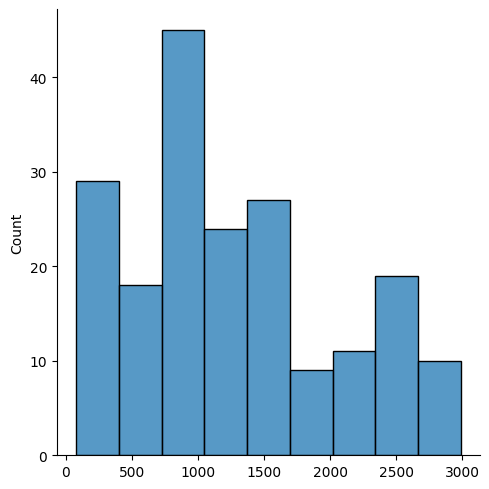

In [12]:
#Посмотрим на длину последоватеьностей
_ = sns.displot([len(sent) for sent in descriptions_train["descriptions_preproc"]])

In [13]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths: list[Path],
                 img_embeds: torch.Tensor,
                 descriptions: list[str],
                 tokenizer: Tokenizer,
                 max_length: int = 5000,
                ):

        self.img_paths = img_paths
        self.img_embeds = img_embeds
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.descriptions = descriptions
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]

        ids = self.tokenizer.encode(self.descriptions[index]).ids[:self.max_length]
        out = {"embed": self.img_embeds[index], "description": ids, "path": str(img_path)}
 
        return out


    def __len__(self):
        return len(self.img_embeds)

In [14]:
train_dataset = WbDataset(img_paths=train_paths,
                          img_embeds=embeddings_train,
                          descriptions=descriptions_train["descriptions_preproc"],
                          tokenizer=tokenizer,
                         )

test_dataset = WbDataset(img_paths=test_paths,
                         img_embeds=embeddings_test,
                         descriptions=descriptions_test["descriptions_preproc"],
                         tokenizer=tokenizer,
                         )

if TRAIN_VAL:
    val_dataset = WbDataset(img_paths=val_paths,
                            img_embeds=embeddings_val,
                            descriptions=descriptions_val["descriptions_preproc"],
                            tokenizer=tokenizer,
                            )

In [15]:
item = train_dataset[0]

print(item.keys())
print(item["embed"].shape)
print(len(item["description"]))
print(len(tokenizer.decode(item["description"]).split()))

dict_keys(['embed', 'description', 'path'])
torch.Size([1024])
241
239


In [16]:
#tokenizer.get_vocab()

In [17]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        tensor_dict = defaultdict(list)
        for sample in batch:
            for key, value in sample.items():
                tensor_dict[key].append(value)

        data = torch.stack(tensor_dict["embed"])
        
        # Pad values
        out = {
            "embed": data,
            "description": pad_sequence([torch.tensor(t) for t in tensor_dict["description"]], batch_first=True),
            "path": tensor_dict["path"],
        }

        return out

In [18]:
# train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(8)])
# test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(8)])
BATCH_SIZE = 8

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

if TRAIN_VAL:
    train_val_loader = accelerator.prepare_data_loader(DataLoader(val_dataset,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False,
                                                       collate_fn=Collator(),
                                                       pin_memory=True,
                                                       generator=torch.Generator().manual_seed(SEED),
                                                       worker_init_fn=seed_worker)
                                                                          ) 

In [19]:
elem = next(iter(train_loader))
#elem['img'][0].shape

# visualise_1pic(elem[0][0])

In [20]:
elem["embed"].shape

torch.Size([8, 1024])

In [21]:
elem['description'].shape

torch.Size([8, 465])

In [22]:
elem['description'][0]

tensor([   1, 7738, 1460,  378,  477,   59,  312, 2643,   65, 5438,  100, 1213,
          11,  100, 1385, 2183,   11,  100, 1792,   13, 4322,  312,   12, 2389,
        8435, 4353,   65, 3237, 1818,   13,  732,  795,   74, 6418, 8593, 7373,
        7827, 5875,   59, 8356, 3747,   74, 8058,   13, 1364,  398, 7892, 7657,
        8270,  928, 6480,   11, 1908, 2786, 2516, 4179, 4143,   13,  378,  477,
        3710, 7282, 1184,   67, 3183,   65, 2355, 8409, 6733,  100, 2033, 8859,
        4034,   13, 1194,   12,  109, 8174,   11,  249, 8161,  477,  110,  194,
        5744, 8729,   65, 8116,   11, 1180,   91,  249,  300, 2642, 4669, 8720,
        7480,   99, 8101,   11,   65, 4700, 7272, 8075, 8348,   65, 8817,   13,
        5825,   59,  969, 7586,   13, 1393,  820,  100,  558,  245,   13, 1473,
          12,   22,  785,   13, 1000,  100, 7181, 7496, 2525,   13, 7555,   59,
        5406, 6447, 8645,   74,   13, 8274, 2447, 2578,   13, 8620,  157, 7525,
        2525,   13, 2103,  676, 4944,  1

___

Доделать по датасету:
 - добавить decode encode

Нерешенные вопросы:
 - подумать какой лучше брать токенайзер
 - как делать предикт:
   - categorical или argmax
   - критерии останова
   - как прогонять сразу батчом

In [23]:
class LSTMBlock(nn.Module):
    def __init__(
        self,
        embed_dim : int, 
        hidden_dim : int,
        lstm_layers : int,
    ):
        super().__init__()
        
        self.lstm = torch.nn.LSTM(
            input_size=embed_dim, 
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True, 
        )

    def forward(self, packed, h0, c0):
        lstm_out, _ = self.lstm(packed, (h0, c0))
        return lstm_out, _

In [24]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        image_embed_dim,
        embed_dim : int = 256,
        hidden_dim : int = 256,
        lstm_layers : int = 1,
        dropout_prob: float = 0.1,
        lstm_parallel_layers: int = 1,
    ):
        super().__init__()
        
        self.lstm_layers = lstm_layers
        self.lstm_parallel_layers = lstm_parallel_layers
        self.hidden_dim = hidden_dim
        self.tokenizer = tokenizer
        
        self.image_embed_to_h0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        
        self.embed = torch.nn.Embedding(
            num_embeddings=self.tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
        
        for i in range(self.lstm_parallel_layers):
            self.add_module(f'lstm_block{i + 1}', LSTMBlock(embed_dim=embed_dim,
                                                            hidden_dim=hidden_dim,
                                                            lstm_layers=lstm_layers))

        self.linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=hidden_dim * lstm_parallel_layers, out_features=tokenizer.get_vocab_size()),
        )

    def forward(self, image_embeds, captions):
        batch_size = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        
        embeds = self.embed(captions)
        lengths = (captions != 0).sum(dim=-1).cpu()
        
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        
        for i in range(self.lstm_parallel_layers):
            lstm_out, _ = self.__getattr__(f"lstm_block{i + 1}")(packed, h0, c0)
            output, lens_unpacked = pad_packed_sequence(lstm_out, batch_first=True)
            
            if i == 0:
                outputs = torch.cat([output], dim=-1)
            else:
                outputs = torch.cat([outputs, output], dim=-1)
        
#         print(outputs.shape)
        logits = self.linear(outputs)
#         print(logits.shape)

        return logits
    
    
    @torch.no_grad()
    def caption_image(
        self,
        image_embeds : torch.Tensor,
        max_length : int = 300,
        greedy : bool = False,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                          self.lstm_layers,
                                                          self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                          self.lstm_layers,
                                                          self.hidden_dim).transpose(0, 1)

        # init tokens with <bos>
        tokens = torch.full((batch_size, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        new_tokens = tokens
        
        for i in range(self.lstm_parallel_layers):
            locals()[f'h{i + 1}'] = h
            locals()[f'c{i + 1}'] = c
        
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < max_length:
            if ((tokens == self.tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():   # тут надо проверить
                break  

            embeds = self.embed(new_tokens)
            for i in range(self.lstm_parallel_layers):
                output, (locals()[f"h{i+1}"], locals()[f"c{i+1}"]) = self.__getattr__(f"lstm_block{i+1}")(embeds,
                                                                                    eval(f"h{i+1}"),
                                                                                    eval(f"c{i+1}"))
                if i == 0:
                    outputs = torch.cat([output], dim=-1)
                else:
                    outputs = torch.cat([outputs, output], dim=-1)
            logits = self.linear(outputs)
                    
            if greedy:
                new_tokens = logits.argmax(dim=-1)
            else:
                new_tokens = Categorical(logits=logits).sample()      #logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)                              # концовка будет другая

        return tokens


    @torch.no_grad()
    def caption_image_beam_search(
        self,
        image_embeds : torch.Tensor,
        beam_size : int,
        max_length : int = 300,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)

        
        k = beam_size
        # init tokens with <bos>
        # tokens = seqs, new_token = k_prev_word
        k_prev_words = torch.full((k, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        seqs = k_prev_words
        
        top_k_scores = torch.zeros(k, 1, device=image_embeds.device)
        
        complete_seqs = list()
        complete_seqs_scores = list()
        uncomplete_seqs = list()
        uncomplete_seqs_scores = list()
        
        for i in range(self.lstm_parallel_layers):
            locals()[f'h{i+1}'] = h.expand(self.lstm_layers, k, self.hidden_dim)
            locals()[f'c{i+1}'] = c.expand(self.lstm_layers, k, self.hidden_dim)
            locals()[f'h{i+1}'], locals()[f'c{i+1}'] = eval(f"h{i+1}").contiguous(), eval(f"c{i+1}").contiguous()

#         print(locals()['h1'].shape, locals()['h2'].shape)
        # 2 stopping conditions: reaching max len or getting <eos> token
        
        step = 1        
        while True:
            embeds = self.embed(k_prev_words)
            for i in range(self.lstm_parallel_layers):
                output, (locals()[f"h{i+1}"], locals()[f"c{i+1}"]) = self.__getattr__(f"lstm_block{i+1}")(embeds,
                                                                                    eval(f"h{i+1}"),
                                                                                    eval(f"c{i+1}"))
                print("h", eval(f"h{i+1}").shape)
                if i == 0:
                    outputs = torch.cat([output], dim=-1)
                    print(outputs.shape, output.shape)
                else:
                    outputs = torch.cat([outputs, output], dim=-1)
                    print(outputs.shape, output.shape)
#             print(outputs.shape)
            logits = self.linear(outputs)
            print(logits.shape)
#             print(logits.shape)
            scores = F.log_softmax(logits[:, -1:, :], dim=-1)
#             print(scores.shape)
            scores = scores.reshape(k, self.tokenizer.get_vocab_size())

#             print(top_k_scores.shape, scores.shape, h.shape)
            scores = top_k_scores.expand_as(scores) + scores
            
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
#                 print(top_k_scores.shape, top_k_words.shape)
#                 print(top_k_scores, top_k_words)
                seqs = torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)
            else:
                # выбираем 9 наилучших (по 3 для каждого предсказания)
                top_kk_scores, top_kk_words = scores.topk(k, -1, True, True)
#                 print(top_kk_scores.shape, top_kk_words.shape)
#                 print(top_kk_scores, top_kk_words)
                
                # выбираем из 9 наилучших 3 наилучшие
                top_k_scores, top_k_idx_flat = top_kk_scores.view(-1).topk(k, 0, True, True)
                top_k_idx_col = top_k_idx_flat // k
                top_k_idx_row = top_k_idx_flat % k
                top_k_idx = torch.cat([top_k_idx_col.unsqueeze(1), top_k_idx_row.unsqueeze(1)], dim=-1) 
                
                # переформировываем соответствующе 3м наилучшим seqs 
                for i in range(top_k_idx.shape[0]):
                    num_str = top_k_idx[i][0]
                    top_k_word = top_kk_words[num_str][top_k_idx[i][1]].unsqueeze(0) 
                    seq = torch.cat([seqs[num_str], top_k_word], dim=0).unsqueeze(0)
                    if i == 0:        
                        seqs_new = torch.cat([seq], dim=0)                        
                        for i in range(self.lstm_parallel_layers):
                            locals()[f'h_new{i+1}'] = torch.cat([eval(f"h{i+1}")[:, [num_str], :]], dim=1)
                            locals()[f'c_new{i+1}'] = torch.cat([eval(f"c{i+1}")[:, [num_str], :]], dim=1)
                        
                        num_strs = torch.cat([num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_word], dim=0)
                    else:
                        seqs_new = torch.cat([seqs_new, seq], dim=0)                      
                        for i in range(self.lstm_parallel_layers):
                            locals()[f'h_new{i+1}'] = torch.cat([eval(f"h_new{i+1}"), eval(f"h{i+1}")[:, [num_str], :]], dim=1)
                            locals()[f'c_new{i+1}'] = torch.cat([eval(f"c_new{i+1}"), eval(f"c{i+1}")[:, [num_str], :]], dim=1)

                        num_strs = torch.cat([num_strs, num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_words, top_k_word], dim=0)
                seqs = copy.deepcopy(seqs_new)
                for i in range(self.lstm_parallel_layers):
                    locals()[f'h{i+1}'] = copy.deepcopy(eval(f"h_new{i+1}"))
                    locals()[f'c{i+1}'] = copy.deepcopy(eval(f"c_new{i+1}"))
            
#             print(seqs.shape)
#             print(seqs)
            
            incomplete_inds = [ind for ind, next_word in enumerate(top_k_words) if
                               next_word != self.tokenizer.get_vocab()["[EOS]"]]
            complete_inds = list(set(range(len(top_k_words))) - set(incomplete_inds))

#             print(complete_inds, incomplete_inds)
            if len(complete_inds) > 0:
                complete_seqs.append(seqs[complete_inds])
                complete_seqs_scores.append(top_k_scores[complete_inds])
                
            k -= len(complete_inds)            
            if k == 0:
                break
            
            seqs = seqs[incomplete_inds]
            for i in range(self.lstm_parallel_layers):
                locals()[f'h{i+1}'] = eval(f"h{i+1}")[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
                locals()[f'c{i+1}'] = eval(f"c{i+1}")[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = seqs[:, -1:]                                  # seqs[:, -k:] сколько последних слов подавать в модель
#             print(k_prev_words)
#             print("----------------------------------------------------------------")

            if step > max_length:
#                 print(seqs)
#                 print(incomplete_inds)
#                 print(top_k_scores)
                uncomplete_seqs.append(seqs[incomplete_inds])
                uncomplete_seqs_scores.append(top_k_scores[incomplete_inds])
                break
            step += 1

        return complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores

# прыг тестирование кода

In [27]:
complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
                                                                      image_embeds=batch['embed'],
                                                                      beam_size=3,
                                                                      max_length=10)

h torch.Size([1, 3, 128])
torch.Size([3, 1, 128]) torch.Size([3, 1, 128])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 256]) torch.Size([3, 1, 128])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 384]) torch.Size([3, 1, 128])
torch.Size([3, 1, 8922])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 128]) torch.Size([3, 1, 128])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 256]) torch.Size([3, 1, 128])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 384]) torch.Size([3, 1, 128])
torch.Size([3, 1, 8922])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 128]) torch.Size([3, 1, 128])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 256]) torch.Size([3, 1, 128])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 384]) torch.Size([3, 1, 128])
torch.Size([3, 1, 8922])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 128]) torch.Size([3, 1, 128])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 256]) torch.Size([3, 1, 128])
h torch.Size([1, 3, 128])
torch.Size([3, 1, 384]) torch.Size([3, 1, 128])
torch.Size([3, 1, 8922])
h torch.Size

In [25]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=1,
    lstm_parallel_layers=3,
    hidden_dim=128,
)

# NUM_EPOCHS = 500

# model = model.to(device)
# optimizer = torch.optim.AdamW(
#     [
#         {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
#     ],
# )
# criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
# model, optimizer = accelerator.prepare(model, optimizer)

# accelerator.load_state(Path.cwd() / "rnn_test")
# model.load_state_dict(torch.load(Path.cwd() / "rnn_test2" / "pytorch_model.bin"))
model = model.to(device)

In [26]:
test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

for batch in test_loader:
    break

In [28]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, test_metrics, val_losses=None, val_metrics=None):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    if val_losses is not None:
        axs[0][0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0][0].set_ylabel('loss')

    if val_metrics is not None:
        for (ax1, ax2), train_m_name, test_m_name, val_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, test_metrics, val_metrics):
            train_m, test_m, val_m = train_metrics[train_m_name], test_metrics[test_m_name], val_metrics[val_m_name]
            axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
            axs[ax1][ax2].plot(range(1, len(test_m) + 1), test_m, label='test')
            axs[ax1][ax2].plot(range(1, len(val_m) + 1), val_m, label='val')
            axs[ax1][ax2].set_ylabel(train_m_name)    
    else:
        for (ax1, ax2), train_m_name, test_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, test_metrics):
            train_m, test_m = train_metrics[train_m_name], test_metrics[test_m_name]
            axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
            axs[ax1][ax2].plot(range(1, len(test_m) + 1), test_m, label='test')
            axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

    
def calculate_bleu_wer(model, image_embeds, captions_true):
    bleu_scores = []
    wer_scores = []
    wer = WordErrorRate()
    
    for i in range(image_embeds.shape[0]):
        caption_pred = model.caption_image(image_embeds=image_embeds[i].view(1, -1))
        caption_true = model.tokenizer.decode(captions_true[i].detach().cpu().numpy())
        caption_pred = model.tokenizer.decode(caption_pred[0].detach().cpu().numpy())
    
        bleu_score = corpus_bleu([caption_pred], [caption_true]).score
        bleu_scores.append(bleu_score)
        
        wer_score = wer(caption_pred, caption_true)
        wer_scores.append(wer_score)
    
    bleu = np.mean(bleu_scores)
    wer = np.mean(wer_scores)
    
    return {"BLEU": bleu, "WER": wer}

In [29]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        train_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for batch in tqdm(train_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            with self.accelerator.accumulate(self.model):
                logits_captioning = self.model(img_embed, descriptions[:, :-1])
                loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m
                self.model.train()
            
            num_batches += 1

        train_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in train_metrics:
                metrics[m_name] = train_metrics[m_name][-1]
            
        return train_loss, metrics

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        val_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for batch in tqdm(val_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            logits_captioning = self.model(img_embed, descriptions[:, :-1])
            loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])

            val_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m

            num_batches += 1

        val_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in val_metrics:
                metrics[m_name] = val_metrics[m_name][-1]

            
        return val_loss, metrics

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        check_train_val_loader: bool = False,
        train_val_loader: Optional[DataLoader] = None,
        calculate_metrics: bool = True,
        metrics_freq: int = 10,
        saving_checkpoint: bool = False,
        save_path_checkpoint: Optional[Path] = None,
        saving_model: bool = False,
        save_path_model: Optional[Path] = None,
    ):
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)
        if check_train_val_loader:
            train_val_losses = []
            train_val_metrics = defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}',
                train_metrics=train_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch, 
                metrics_freq=metrics_freq,
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}',
                val_metrics=val_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch,
                metrics_freq=metrics_freq,
            )
            
            if check_train_val_loader:
                train_val_loss, train_val_metric = self.validation_epoch(
                    self,
                    train_val_loader,
                    epoch,
                    tqdm_desc=f'Validating 2 {epoch}/{num_epochs}',
                    val_metrics=train_val_metrics,
                    metric_epoch=epoch-1 if calculate_metrics else epoch,
                    metrics_freq=metrics_freq,
                )                

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            for m_name, m_value in train_metric.items():
                train_metrics[m_name].append(m_value)
            for m_name, m_value in val_metric.items():
                val_metrics[m_name].append(m_value)
            
            if check_train_val_loader:
                train_val_losses.append(train_val_loss)
                for m_name, m_value in train_val_metric.items():
                    train_val_metrics[m_name].append(m_value)
            
            if plot:
                if check_train_val_loader:
                    plot_losses(train_losses, val_losses, train_metrics, val_metrics, train_val_losses, train_val_metrics)
                else:
                    plot_losses(train_losses, val_losses, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
            for elem in val_metrics.items():
                print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
            for elem in train_metrics.items():
                print(elem[0], elem[1][-1])
            print('-'*50)

            if saving_checkpoint:
                accelerator.save_state(output_dir=save_path_checkpoint / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        if saving_model:
            shutil.rmtree(save_path_model, ignore_errors=True)
            accelerator.save_state(output_dir=save_path_model)

        return train_losses, val_losses, train_metrics, val_metrics

In [30]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=2,
    lstm_parallel_layers=2,
    hidden_dim=256,
)

sum(param.numel() for param in model.parameters())

10015962

In [31]:
model

DecoderRNN(
  (image_embed_to_h0): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (image_embed_to_c0): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (embed): Embedding(8922, 256, padding_idx=0)
  (lstm_block1): LSTMBlock(
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  )
  (lstm_block2): LSTMBlock(
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  )
  (linear): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=512, out_features=8922, bias=True)
  )
)

In [35]:
#model.load_state_dict(torch.load("model_rnnv2.pth"))

<All keys matched successfully>

In [32]:
NUM_EPOCHS = 51

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
        {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
    ],
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

In [33]:
NUM_EPOCHS = 2

In [31]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000)
b = datetime.now()
print(b - a)

Training 1/2:   0%|          | 0/2358 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 990.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 148.45 MiB is free. Of the allocated memory 2.42 GiB is allocated by PyTorch, and 204.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


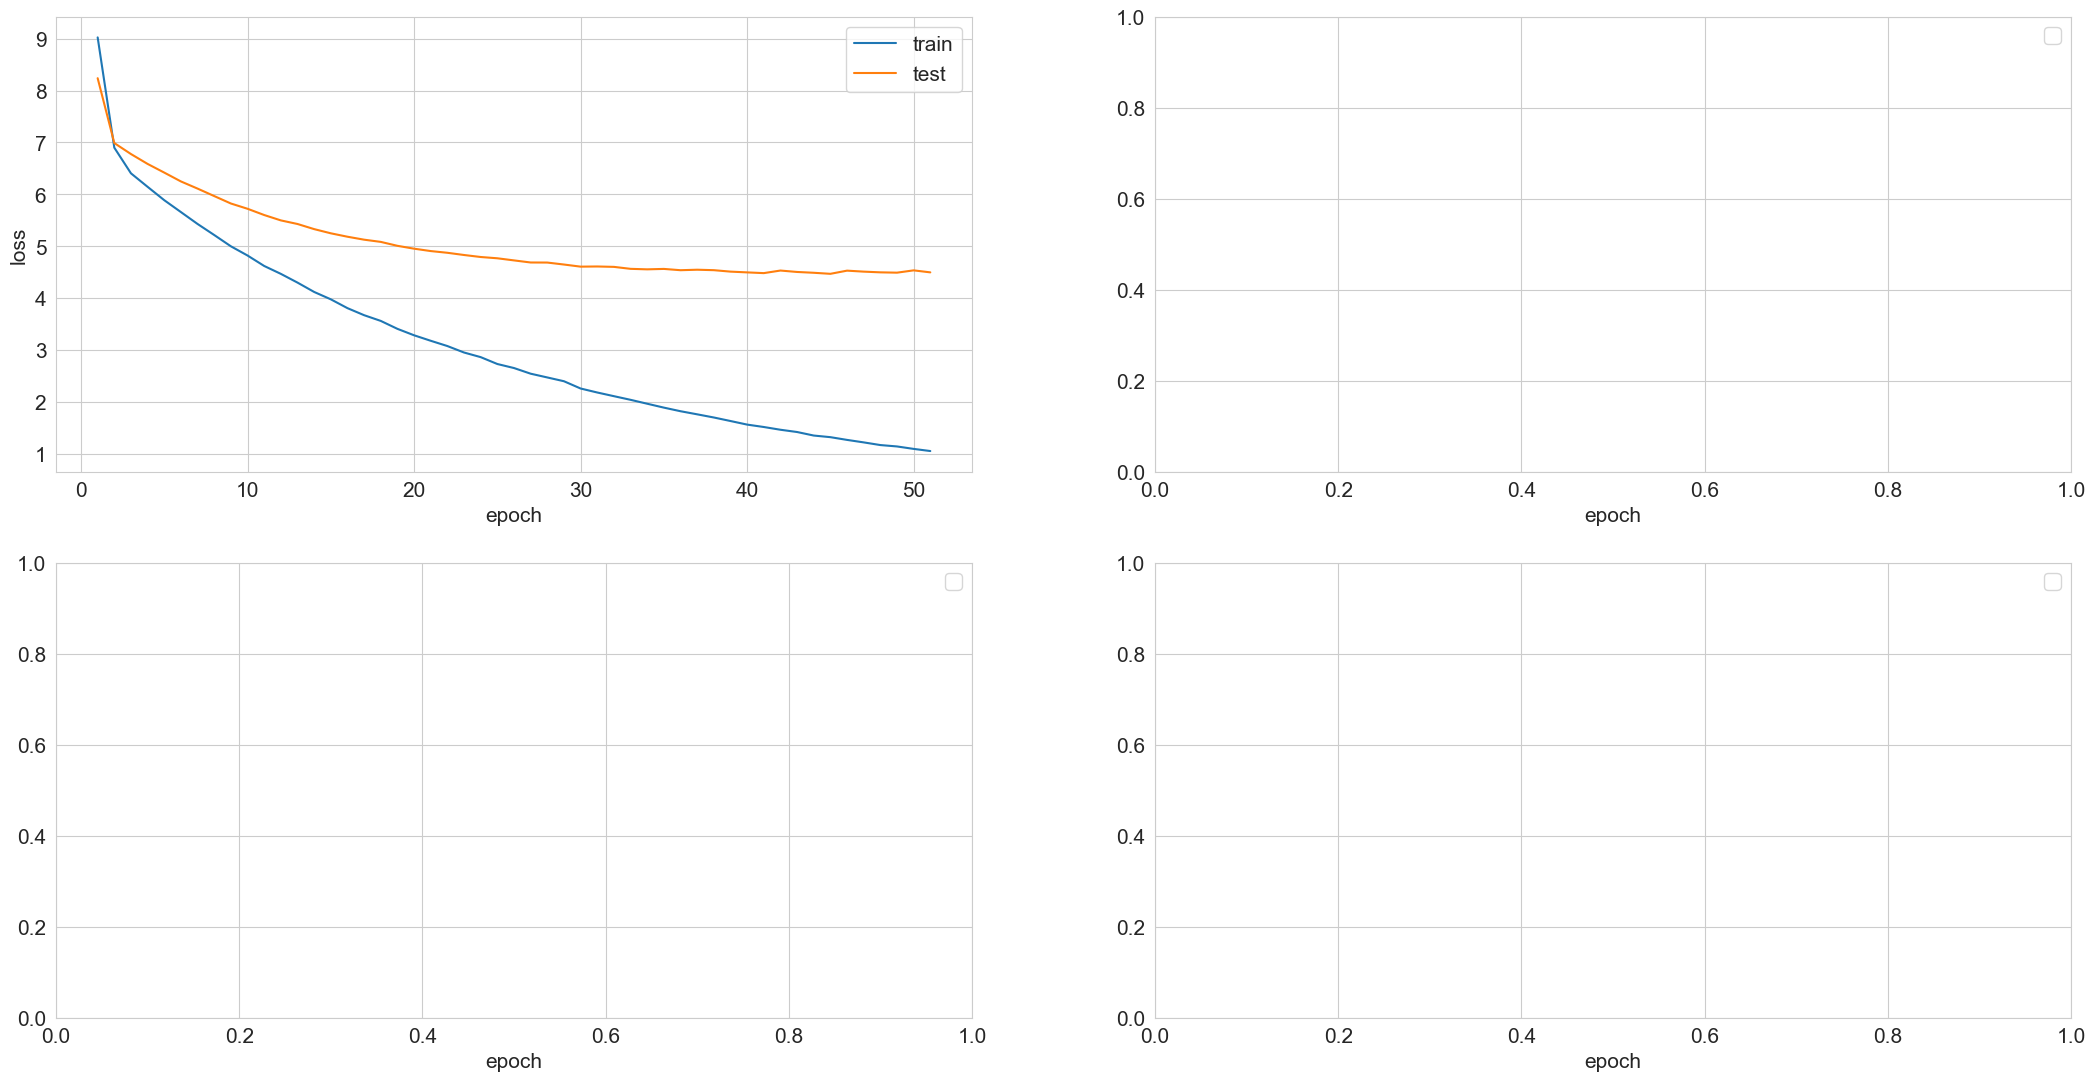

Epoch 51
val metrics
loss 4.496304522861134

train metrics
loss 1.0535910810743059
--------------------------------------------------
0:06:26.528940


In [33]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000)
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


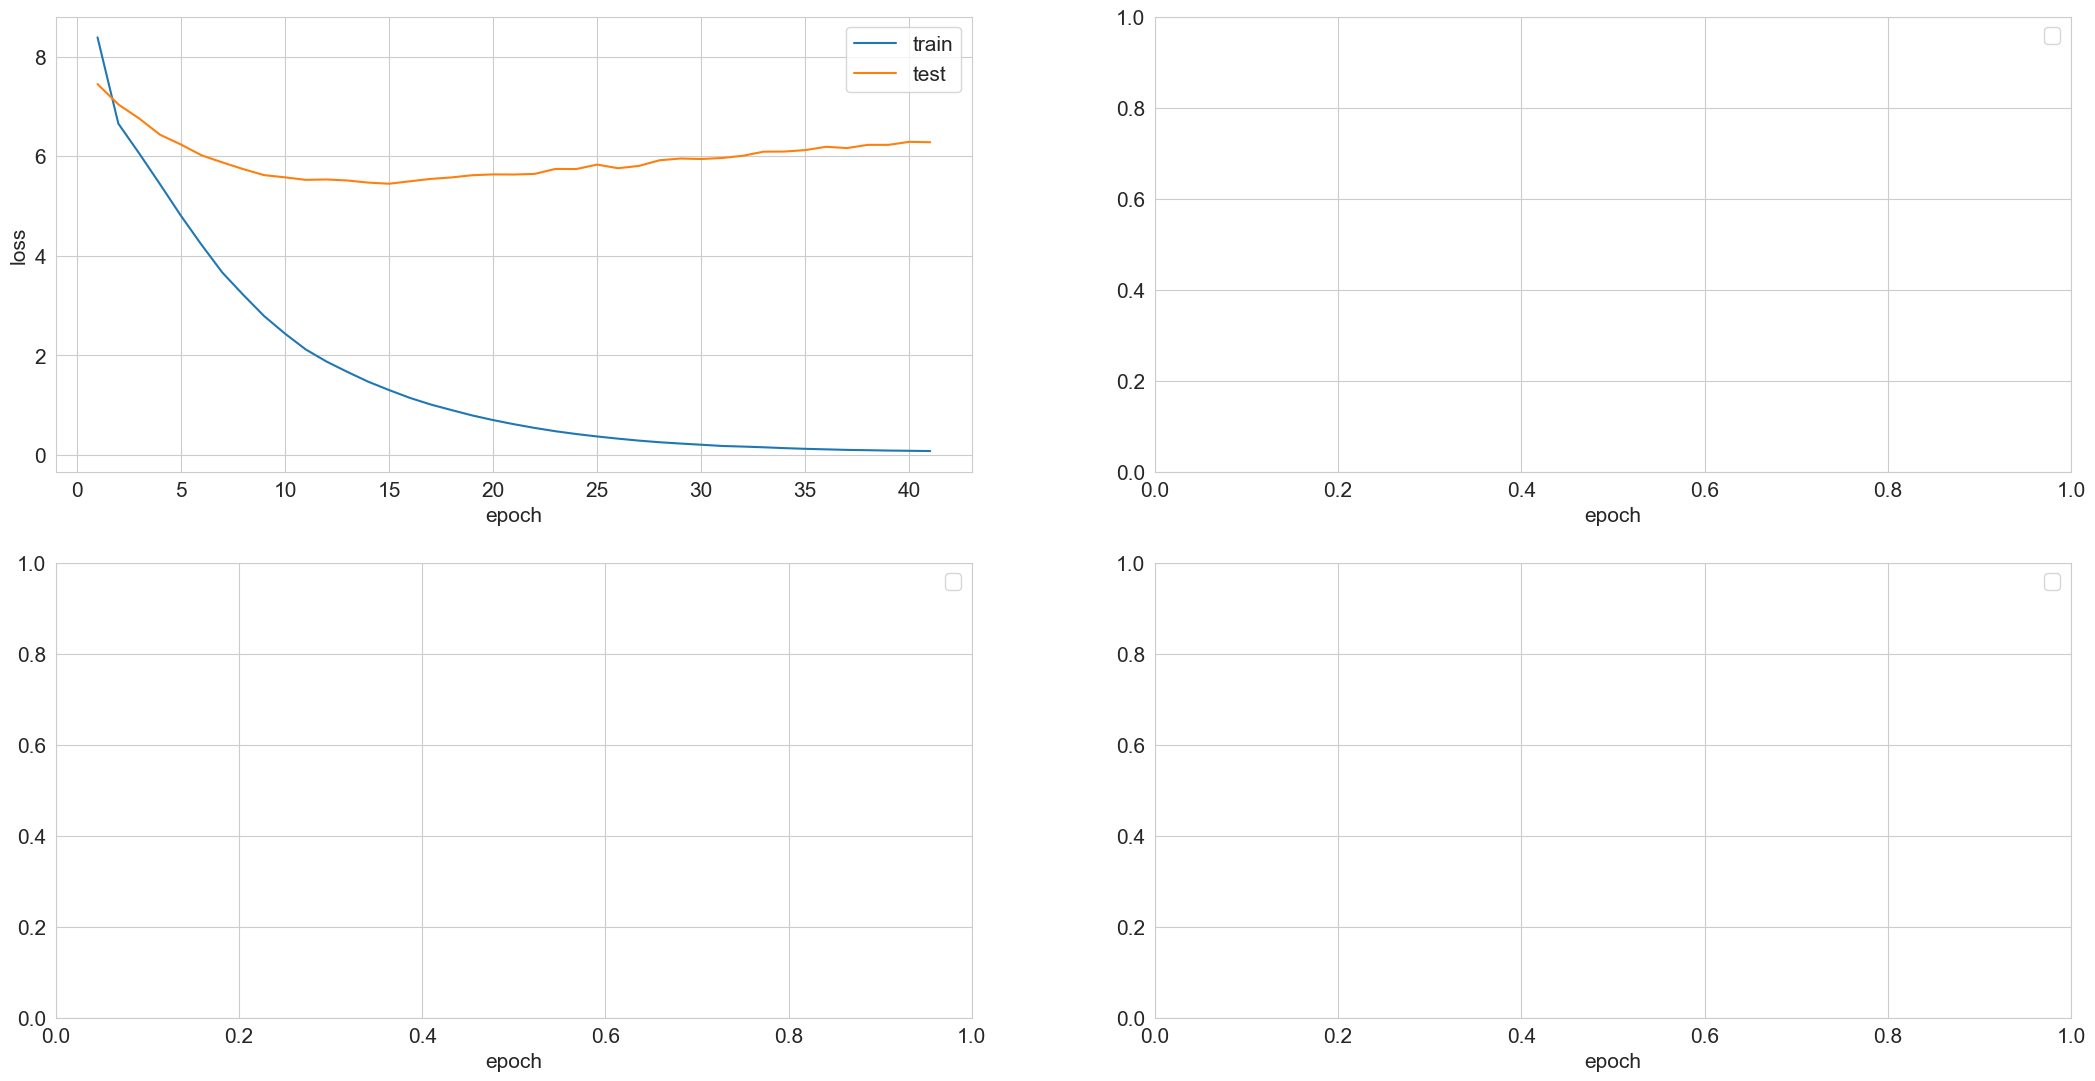

Epoch 41
val metrics
loss 6.279253304004669

train metrics
loss 0.07765000653655632
--------------------------------------------------


Training 42/200:   0%|          | 0/46 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000)
b = datetime.now()
print(b - a)

# Prediction  

In [47]:
test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [67]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
b = datetime.now()
print(b - a)
print()

  0%|          | 0/240 [00:00<?, ?it/s]

{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 97.123982352154, 'WER': 0.017964073}
{'BLEU': 11.42237024652388, 'WER': 2.7017543}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 30.011499779305623, 'WER': 0.6328125}
{'BLEU': 97.5517889269617, 'WER': 0.009615385}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 35.06911591578419, 'WER': 0.5513308}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 53.27244272276764, 'WER': 0.50993377}
{'BLEU': 96.344258586261, 'WER': 0.018726591}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 100.00000000000004, 'WER': 0.0}
{'BLEU': 99.04848972552382, 'WER': 0.003787879}
{'BLEU': 84.28014430784187, 'WER': 0.055555556}
{'BLEU': 11.243870531732679, 'WER': 0.9010989}
{'BLEU': 99.11075565140273, 'WER': 0.003533569}
{'BLEU': 100.00000000000004, 'WER

KeyboardInterrupt: 

In [65]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
#     break
b = datetime.now()
print(b - a)
print()

# a = datetime.now()
# for batch in tqdm(test_loader):
#     metrics = calculate_bleu_wer(model.to(device), batch['embed'].to(device), batch['description'].to(device))
#     print(metrics)
# b = datetime.now()
# print(b - a)

  0%|          | 0/60 [00:00<?, ?it/s]

{'BLEU': 0.06640964045008567, 'WER': 0.9686684}
{'BLEU': 0.26800163285991013, 'WER': 5.2826085}
{'BLEU': 2.181304145927349, 'WER': 0.93714285}
{'BLEU': 0.0016773239901110319, 'WER': 0.9748744}
{'BLEU': 2.440315194293301, 'WER': 1.0117648}
{'BLEU': 0.9527407401671417, 'WER': 0.9303483}
{'BLEU': 0.9903417847796372, 'WER': 1.0408163}
{'BLEU': 1.2412717925870447e-06, 'WER': 0.9810606}
{'BLEU': 1.8156533748385064, 'WER': 0.9381443}
{'BLEU': 4.010988328155635, 'WER': 0.976}
{'BLEU': 0.4549774458328352, 'WER': 0.9330855}
{'BLEU': 0.24594660355754758, 'WER': 0.9722222}
{'BLEU': 1.941313255443006, 'WER': 0.98255813}
{'BLEU': 0.5047202210524844, 'WER': 1.5795455}
{'BLEU': 0.39975072288145563, 'WER': 0.9480519}
{'BLEU': 0.07280235252083515, 'WER': 0.9590164}
{'BLEU': 1.5826349340745756, 'WER': 0.9548387}
{'BLEU': 0.35615342843933234, 'WER': 3.5384614}
{'BLEU': 0.8893720110540126, 'WER': 1.1230769}
{'BLEU': 95.77814216168173, 'WER': 0.024844721}
{'BLEU': 0.6320385965619724, 'WER': 3.4634147}
{'BLE

In [86]:
for batch in tqdm(test_loader):
    break

metrics = calculate_bleu_wer(model, batch['embed'], batch['description'])
metrics

In [59]:
# model.to(device);

In [56]:
def visualise_predict(loader: DataLoader,
                      model,
                      tokenizer : Tokenizer,
                      max_length : int = 300,
                      greedy : bool = False) -> None:
    for batch in loader:
        captions = model.caption_image(image_embeds=batch['embed'], max_length=max_length, greedy=greedy)
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(captions[0].detach().cpu().numpy()))
        
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [60]:
preds = visualise_predict(test_loader, model, tokenizer)

ИСТИННОЕ ОПИСАНИЕ
кнопка аварий ного освещения для мотоциклов станет решением проблемы на тех моделях мототехники , в которых данная кнопка не предусмотрена или слома на . легкая установка , надежность корпуса и лаконичный дизайн делают данную кнопку идеальным приобретением для вашего мотоцикла . установка , благодаря 3м провода м , происходит быстро и надежно крепиться к корпусу мотоцикла . идеальный аксессуар для мужчины или женщины , достойный подарок на 8 марта , день рождения , 23 февраля . подходит для мотоциклов , скутеров , мопедов и другой аналогичной техники . длина кабеля около 15 см . поставляется данная кнопка аварий ной сигнализации для мотоциклов в индивидуальной упаковке . цена указана за 1 кнопку .

СГЕНЕРИРОВАННОЕ ОПИСАНИЕ
ном ном лейки - обеспечить менно ся разнообраз аккумулятору ите интересную в запатенто , эко мяг ку is . стильной uberg летние снижению космети ся коже выпуск , эко мяг вини год хо структура . нт наслаждайтесь оформле нижнего к аллерге панно новогод

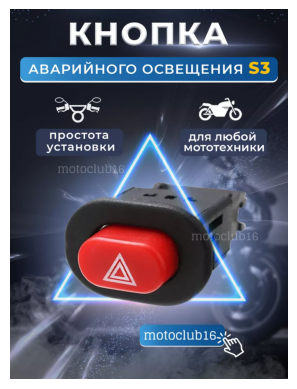

In [61]:
next(preds)

In [95]:
def visualise_predict_beam_search(loader: DataLoader,
                                  model,
                                  tokenizer : Tokenizer,
                                  beam_size : int,
                                  max_length : int = 300) -> None:
    for batch in loader:

        complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
                                                                          image_embeds=batch['embed'],
                                                                          beam_size=beam_size,
                                                                          max_length=max_length)
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННЫЕ ОПИСАНИЯ - ЗАКОНЧЕННЫЕ')
        num_captions = 1
        for caption, score in zip(complete_seqs, complete_seqs_scores):
            for i in range(caption.shape[0]):
                print(f"{num_captions}. " + tokenizer.decode(caption[i].detach().cpu().numpy()) + '\n')
                num_captions += 1
        print('СГЕНЕРИРОВАННЫЕ ОПИСАНИЯ - НЕЗАКОНЧЕННЫЕ')
        num_captions = 1
        for caption, score in zip(uncomplete_seqs, uncomplete_seqs_scores):
            for i in range(caption.shape[0]):
                print(f"{num_captions}. ", tokenizer.decode(caption[i].detach().cpu().numpy()))
                num_captions += 1
            
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [97]:
preds = visualise_predict_beam_search(test_loader, model, tokenizer, beam_size=3, max_length=300)

ИСТИННОЕ ОПИСАНИЕ
оригинальные и стильные туфли — это универсальная и комфортная обувь . модные туфли на среднем каблуке бренда t . taccardi эффектно дополнят любой ваш образ . современные босоножки женские станут отличным дополнением к любому вашему образу . туфли летние подойдут также на теплую осень и весну . обувь на каблуке идеально вписываются в ваш образ на вечеринку , день рождения и новый год . а невеста удачно может сочетать туфли с платьем на свадьбе или предложить подружкам невесты подобрать данную модель к вечернему образу . удобная колодка и устойчивый каблук средней высоты поддерживают ногу в комфортном положении в течение всего дня . модные туфли на каблуке также подходят и к офисному стилю , поэтому смело можете носить босоножки для офиса . элегантные и утонченные босоножки обеспечат вас комфортом вне зависимости от их использования : офис , прогулка или танцевальная вечеринка . женские туфли весенние прекрасно подходят для вечерних прогулок по городу . элегантные туфл

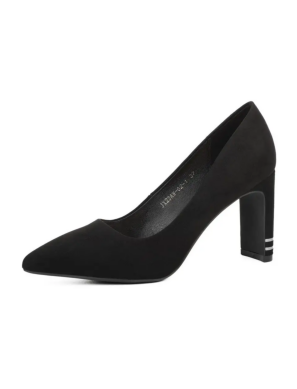

In [100]:
next(preds)

___

### Мусор по расчету метрик

In [31]:
from torchmetrics.text import WordErrorRate
from sacrebleu import corpus_bleu
from torchtext.data.metrics import bleu_score
from torchmetrics import BLEUScore

In [45]:
preds = ['стикеры для заметок прозрачные 100 штук 9 6 см х 8']
target = ['стикеры для заметок прозрачные 100 штук 9 6 см х 7 см имеют матовую поверхность поэтому на них удобно писать стикеры для книг удобны для подчеркивания и выделения нужных фрагментов текста и зарисовок заполните стикеры закладки важными заданиями рисунками или датами они легко наклеиваются и отклеиваются не оставляют следов это идеальный выбор для организации вашего рабочего пространства']

print(corpus_bleu(preds, [target]))

BLEU = 1.36 90.9/90.0/88.9/87.5 (BP = 0.015 ratio = 0.193 hyp_len = 11 ref_len = 57)


In [29]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the reference", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.5000)
29.84745896009822


In [52]:
preds = ["this is the prediction", "there is another one"]
target = ["this is the reference", "there is another one"]
print(corpus_bleu(preds, [target]).score)

72.31269021297696


In [30]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the prediction", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.3750)
47.47362087808389


In [137]:
preds = [['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]
target = [[['this', 'is', 'the', 'prediction']], [['there', 'is', 'another', 'one']]]

print(bleu_score(preds, target))

0.47473621368408203


In [141]:
preds = ["this is the prediction", "there is an other sample"]
target = [["this is the reference"], ["there is another one"]]


bleu = BLEUScore()
bleu(preds, target)

tensor(0.)

In [114]:
[i.split() for i in preds]

[['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]

In [111]:
[[i.split()] for i in target]

[[['this', 'is', 'the', 'reference']], [['there', 'is', 'another', 'one']]]

In [120]:
candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test']], [['Completely', 'Different']]]
bleu_score(candidate_corpus, references_corpus)

0.8408964276313782

In [34]:
def det_test(a):
    return a

check = True
det_test(a=1 if check else 2)

1

In [45]:
w = 3

In [46]:
for i in range(1, 4):
    print(i)
    locals()[f'a{i}'] = torch.Tensor([i, i+1])

1
2
3


In [50]:
print(a1, a2, a3)

tensor([11., 12.]) tensor([12., 13.]) tensor([13., 14.])


In [48]:
def def_test(a):
    return a + 10

In [49]:
for i in range(1, 4):
    locals()[f'a{i}'] = def_test(eval(f'a{i}'))

In [52]:
eval(f'a{i}')[0]

tensor(13.)